# Iris Flower Data Set: Model Analysis

## Libraries

In [1]:
import os
os.environ['MACOSX_DEPLOYMENT_TARGET'] = '10.15'

In [2]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy as sp
import itertools
import pystan
import arviz
from sklearn import decomposition

## Data

In [3]:
iris_df = pd.read_csv('Iris.csv')
iris_df['species'] = iris_df['species'].astype('category')
labels = iris_df.species.cat.categories
features = iris_df.drop(columns=['species']).columns.to_list()
print('labels:', list(labels))
print('features:', features)
iris_df.describe()

labels: ['setosa', 'versicolor', 'virginica']
features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

## Data Exploration

Firstly, we will plot a histogram for each feature, and labeled it by flower.  

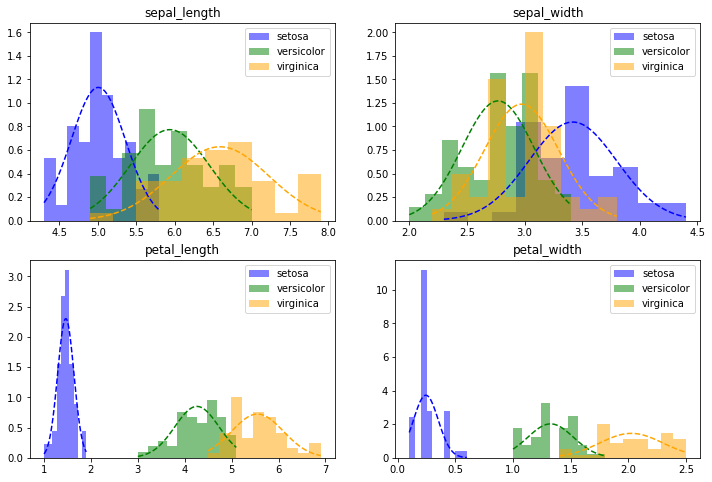

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
colors = {'setosa':'b', 'versicolor':'g', 'virginica':'orange'}
for (feature, (i, j)) in zip(features, list(itertools.product(range(2), repeat=2))):
    axs[i][j].set_title(feature)
    for label in labels:
        data = iris_df[iris_df.species == label][feature]
        axs[i][j].hist(data, label=label, alpha=0.5, density=True, 
                       color=colors[label], linestyle='dashed')
        
        xs = np.linspace(data.min(), data.max(), 100)
        ys = norm.pdf(xs, loc=data.mean(), scale=data.std())
        axs[i][j].plot(xs, ys, color=colors[label], linestyle='dashed')
    axs[i][j].legend()

We noticed, that petal length and width allows easier seperation than sepal length and width, but it will still be a little difficult to distinguish between Versicolor and Virginica.

Then, we will plot a histogram for each feature, without the labels, which is the data that our models will be fed with.  
And whether it will be with or without dimensionality reduction, is dependent on the model.

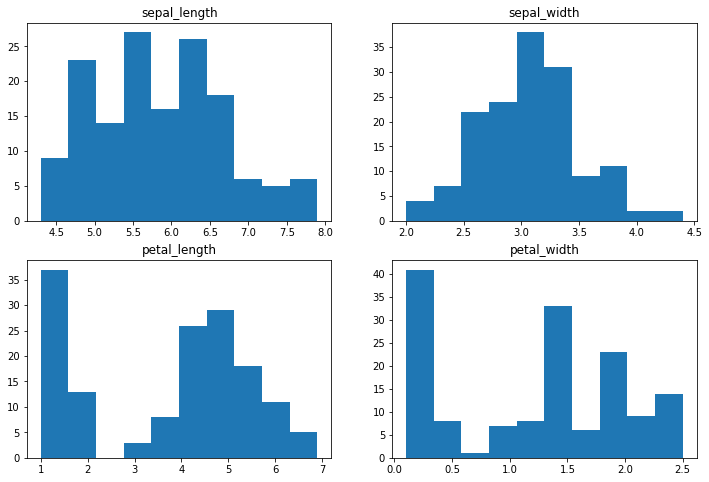

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
for (feature, (i, j)) in zip(features, list(itertools.product(range(2), repeat=2))):
    axs[i][j].set_title(feature)
    axs[i][j].hist(iris_df[feature])

## Models

###### Notations:
N = # of data points in Iris dataset  
D = # of features  
C = # of clusters  
$
i \in [1, N]\\
d \in [1, D]\\
c \in [0, C)\\
X\text{'s shape: } (N, D)\\
y\text{'s shape: } (N,)
$
###### Model 1 - dimensionality reduction with PCA --> GMM:  
$
\mu_c \sim \mathcal{N}(0,10)\\
\sigma_c \sim \mathcal{Lognormal}(0,10)\\
\log{p(y_i|\mu,\sigma)} = \log{(\frac{1}{3}\exp{(\log{p(y_i|\mu_0,\sigma_0)})} + \frac{1}{3}\exp{(\log{p(y_i|\mu_1,\sigma_1)})} + \frac{1}{3}\exp{(\log{p(y_i|\mu_2,\sigma_2)})})}
$
###### Model 2 - dimensionality reduction with Linear Regression --> GMM:  
$
\mu_c \sim \mathcal{N}(0,10)\\
\sigma_c \sim \mathcal{Lognormal}(0,10)\\
\beta_d \sim \mathcal{N}(\text{PCA-eigenvalue}_d,0.01)\\
y = X \cdot \beta\\
\log{p(y_i|\mu,\sigma)} = \log{(\frac{1}{3}\exp{(\log{p(y_i|\mu_0,\sigma_0)})} + \frac{1}{3}\exp{(\log{p(y_i|\mu_1,\sigma_1)})} + \frac{1}{3}\exp{(\log{p(y_i|\mu_2,\sigma_2)})})}
$

In [6]:
model_1 = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> C; // number of clusters
    vector[N] y; // data
}

parameters {
  ordered[C] mu;
  vector<lower=0>[C] sigma;
}

model {  
    mu ~ normal(0, 10);
    sigma ~ lognormal(0, 10);
    for (n in 1:N) {
        target += log_sum_exp([
            normal_lpdf(y[n] | mu[1], sigma[1]),
            normal_lpdf(y[n] | mu[2], sigma[2]),
            normal_lpdf(y[n] | mu[3], sigma[3])
        ]);
    }
}
"""
gmm_1 = pystan.StanModel(model_code=model_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be6860bea44ec94ac7d934a4c33c5b95 NOW.


In [7]:
model_2 = """
data {
    int<lower=1> D; // number of dimensions
    int<lower=0> N; // number of data points
    int<lower=0> C; // number of clusters
    matrix[N, D] X; // data
    vector[D] reg_prior; // priors from the PCA for linear regression
}

parameters {
  matrix[D,1] beta;
  ordered[C] mu;
  vector<lower=0>[C] sigma;
}

model {
    matrix[N,1] mu_reduced;
    vector[N] mu_reduced_vec;
    for (d in 1:D){
        beta[d] ~ normal(reg_prior[d], 0.01);
    }
    
    mu_reduced = X * beta;
    mu_reduced_vec = to_vector(mu_reduced);
    
    mu ~ normal(0, 10);
    sigma ~ lognormal(0, 10);
    for (n in 1:N) {
        target += log_sum_exp([
            normal_lpdf(mu_reduced_vec[n] | mu[1], sigma[1]),
            normal_lpdf(mu_reduced_vec[n] | mu[2], sigma[2]),
            normal_lpdf(mu_reduced_vec[n] | mu[3], sigma[3])
        ]);
    }
}
"""
gmm_2 = pystan.StanModel(model_code=model_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c523500e9d324fdce6f4333f0a764e57 NOW.


## Data Preperations

Firstly, we standartize the data. 

In [8]:
species_col = iris_df['species']
mean = iris_df.drop(columns=['species']).mean()
std = iris_df.drop(columns=['species']).std()
iris_df = iris_df.drop(columns=['species']).apply(lambda x: (x-mean)/std, axis=1)
iris_df['species'] = species_col
iris_df.describe()

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


sepal_length   sepal_width  petal_length   petal_width
count  1.500000e+02  1.500000e+02  1.500000e+02  1.500000e+02
mean  -1.515825e-15 -1.657933e-15 -1.563194e-15 -7.579123e-16
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -1.863780e+00 -2.430844e+00 -1.563497e+00 -1.439627e+00
25%   -8.976739e-01 -5.858010e-01 -1.223442e+00 -1.177559e+00
50%   -5.233076e-02 -1.245404e-01  3.351431e-01  1.327811e-01
75%    6.722490e-01  5.673506e-01  7.602119e-01  7.879511e-01
max    2.483699e+00  3.104284e+00  1.780377e+00  1.705189e+00

Then, we performed PCA for dimensionallity reduction for the first model, and for priors of the second model.

PCA eigenvalues: [ 0.52237162 -0.26335492  0.58125401  0.56561105]


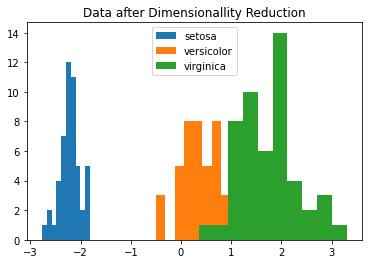

In [9]:
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(iris_df.drop(columns=['species']).to_numpy())
print('PCA eigenvalues:', pca.components_[0])
_, ax = plt.subplots(1,1)
ax.set_title('Data after Dimensionallity Reduction')
for label in labels:
    idxs = iris_df[iris_df['species']==label].index
    ax.hist(pca_result[idxs], label=label)
_ = ax.legend()

In [10]:
# Inverting the sign of the second column for the PCA to be positive:
#iris_df[iris_df.columns[1]] = iris_df[iris_df.columns[1]].apply(lambda x: -x)
#result = pca.fit_transform(iris_df.drop(columns=['species']).to_numpy())
#pca.components_[0]

This is the data for each model.

In [11]:
data_1 = {
    'N': len(iris_df),
    'C': len(labels),
    'y': (iris_df.drop(columns=['species']).to_numpy()@pca.components_[0].reshape(4,1)).ravel()
}
data_2 = {
    'D': len(features),
    'N': len(iris_df),
    'C': len(labels),
    'X': iris_df.drop(columns=['species']).to_numpy(),
    'reg_prior': pca.components_[0]
}

## Inference

Inference for Stan model: anon_model_be6860bea44ec94ac7d934a4c33c5b95.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -2.21  7.4e-4   0.03  -2.27  -2.23  -2.21  -2.19  -2.16   1375    1.0
mu[2]       0.7    0.01    0.2   0.38   0.53   0.66   0.85   1.12    282   1.01
mu[3]       1.5    0.01   0.21   1.07   1.35   1.53   1.66   1.83    328   1.01
sigma[1]    0.2  5.9e-4   0.02   0.17   0.19    0.2   0.22   0.25   1246    1.0
sigma[2]   0.62  7.4e-3   0.14   0.41   0.52    0.6   0.71   0.94    353    1.0
sigma[3]   0.73  5.7e-3   0.13   0.52   0.63   0.72   0.83   1.02    544   1.01
lp__     -41.76    0.11   2.09  -46.8 -42.86 -41.42 -40.18 -38.78    337   1.01

Samples were drawn using NUTS at Mon Jul 20 02:58:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction 

/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6101cef60>,
      dtype=object)

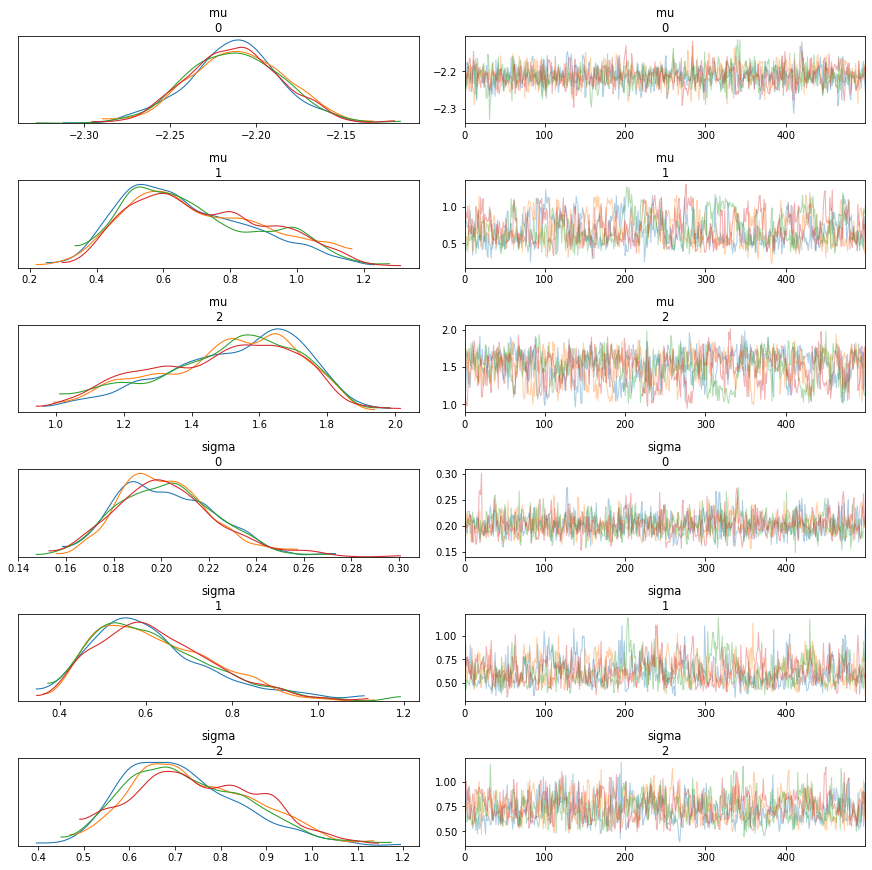

In [12]:
fit_1 = gmm_1.sampling(data=data_1, iter=1000, chains=4, init=lambda: {'mu': [-3, 0, 3], 'sigma': [1,1,1]})
print(fit_1)
arviz.plot_trace(fit_1)

Inference for Stan model: anon_model_c523500e9d324fdce6f4333f0a764e57.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1,1]   0.51  3.4e-4 9.9e-3   0.49    0.5   0.51   0.52   0.53    855    1.0
beta[2,1]  -0.26  2.5e-4 9.5e-3  -0.28  -0.27  -0.26  -0.26  -0.24   1437    1.0
beta[3,1]   0.57  3.1e-4   0.01   0.55   0.57   0.57   0.58   0.59   1041    1.0
beta[4,1]   0.56  2.9e-410.0e-3   0.54   0.55   0.56   0.57   0.58   1161    1.0
mu[1]      -2.18  1.1e-3   0.04  -2.25  -2.21  -2.18  -2.16  -2.11   1051    1.0
mu[2]       0.66    0.01    0.2   0.34   0.52   0.63   0.81   1.08    333   1.01
mu[3]        1.5  9.2e-3    0.2   1.07   1.36   1.54   1.64   1.82    472   1.01
sigma[1]     0.2  5.8e-4   0.02   0.16   0.19    0.2   0.21   0.24   1260    1.0
sigma[2]    0.59  6.2e-3   0.13   0.38   0.49   0.58   0.67    0.9    458   1.01
sig

/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ork/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd61131c5c0>,
      dtype=object)

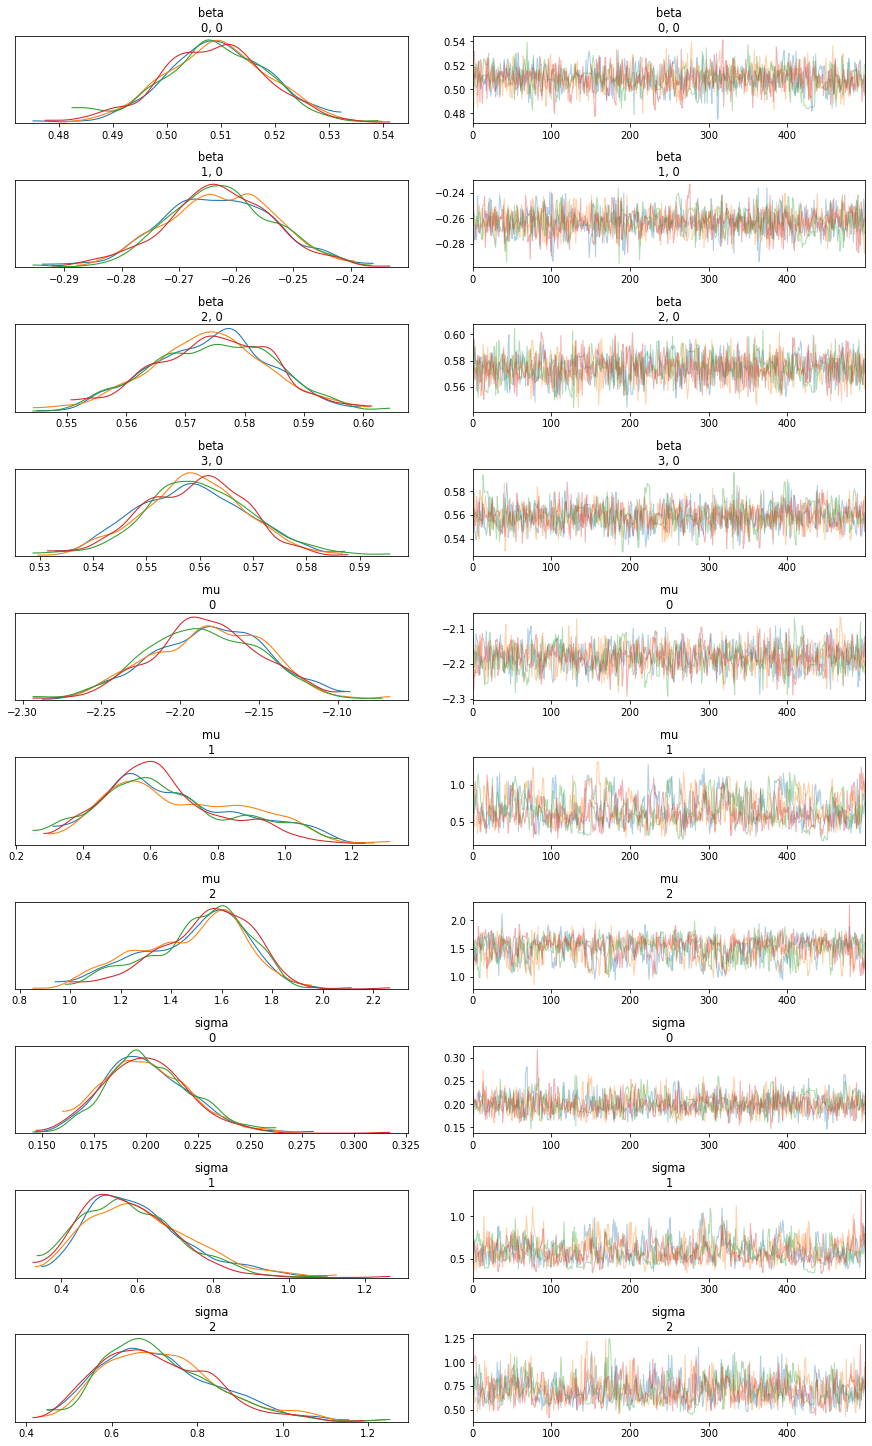

In [13]:
fit_2 = gmm_2.sampling(data=data_2, iter=1000, chains=4, init=lambda: {'mu': [-3, 0, 3], 'sigma': [1,1,1]})
print(fit_2)
arviz.plot_trace(fit_2)

In [14]:
la1 = fit_1.extract(permuted=True)
la2 = fit_2.extract(permuted=True)

In [15]:
SAMPLES = [
    ['Model1', la1['mu'], la1['sigma'], None],
    ['Model2', la2['mu'], la2['sigma'], la2['beta']]
]

## Model Cheking

### Posteriors

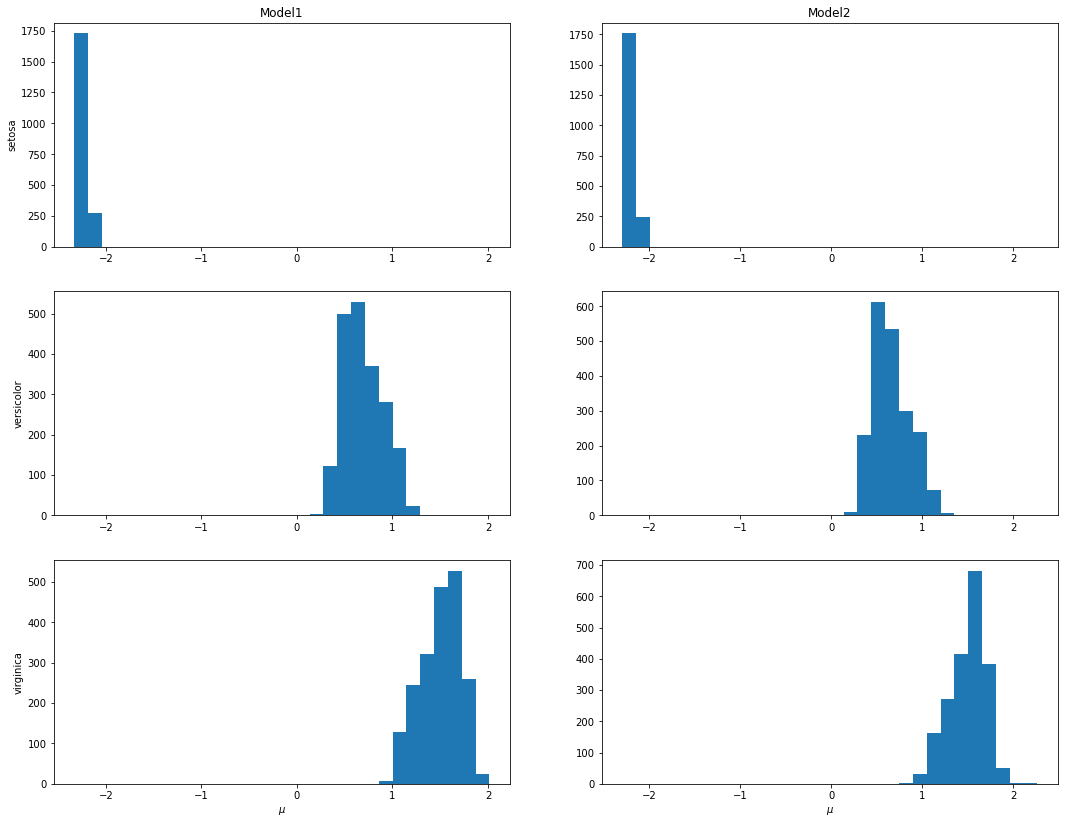

In [16]:
fig, ax = plt.subplots(len(labels), len(SAMPLES), figsize=(18, 14))
for m, (model, mus, _, _) in enumerate(SAMPLES):
    ax[0][m].set_title(model)
    ax[-1][m].set_xlabel(r'$\mu$')
    rng = (mus.min(), mus.max())
    for i, c in enumerate(labels):
        ax[i][0].set_ylabel(c)
        ax[i][m].hist(mus[:,i], bins=30, range=rng)

In the graphs above we can see that both model's posteriors produced similar distributions for each flower, and it's hard to tell the difference based on the posteriors only.

Next, for the first model and for each flower, we will will plot 3 simulations.  
We will also compare them with the data that was given to the first model (represented by the blue bars).  
This will allow us to get a general feel for the quality of first model.  
We will not perform simulations for the second model since it was given 4-dimensional data and reduced the dimensions within it.

In [17]:
def draw_value(mu, sigma):
    return sp.stats.norm.rvs(loc=mu, scale=sigma)

def simulate(mus, sigmas, n_sim):
    simulations = []
    n_groups = mus.shape[1]
    for _ in range(n_sim):
        y_rep = []
        for i in range(n_groups):
            idx = np.random.choice(np.arange(mus.shape[0]))
            y_rep.append(draw_value(mus[idx,i], sigmas[idx,i]))
        simulations.append(y_rep)
    
    return np.array(simulations)

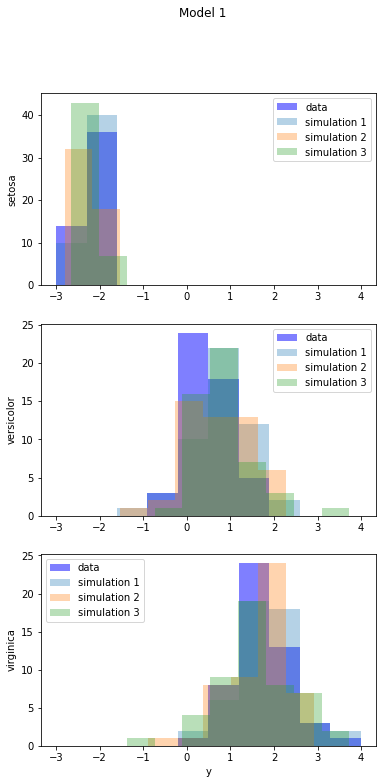

In [18]:
n_sim = len(iris_df)
fig, ax = plt.subplots(3,1, figsize=(6, 12))
fig.suptitle('Model 1')
ax[-1].set_xlabel("y")
_, mus, sigmas, _ = SAMPLES[0]
for s in range(3):
    simulations = simulate(mus, sigmas, n_sim)
    rng = (simulations.min(), simulations.max())
    for j, species in enumerate(labels):
        if s == 0:
            ax[j].hist(data_1['y'][50*j:50*(j+1)], color="blue", label="data", range=rng, alpha=0.5)
            ax[j].set_ylabel(species)
        samp_num = iris_df['species'].where(iris_df['species']==species).count()
        ax[j].hist(np.random.choice(simulations[:,j], samp_num), 
                      alpha=0.33, label="simulation "+str(s+1), range=rng)
        ax[j].legend()

### P-Values

We choose to examine 3 test quantities and calculate their P-values for the first model:  
Min, Max, Median
 
We will not show P-values for the second model since it was given 4-dimensional data and reduced the dimensions within the model.

In [19]:
def simulate_for_pvalues(mus, sigmas, n_sim, n_draws=50):
    simulations = []
    n_groups = mus.shape[1]
    for _ in range(n_sim):
        y_rep = []
        for i in range(n_groups):
            for j in range(n_draws):
                idx = np.random.choice(np.arange(mus.shape[0]))
                y_rep.append(draw_value(mus[idx,i], sigmas[idx,i]))
        simulations.append(y_rep)
    
    return np.array(simulations)

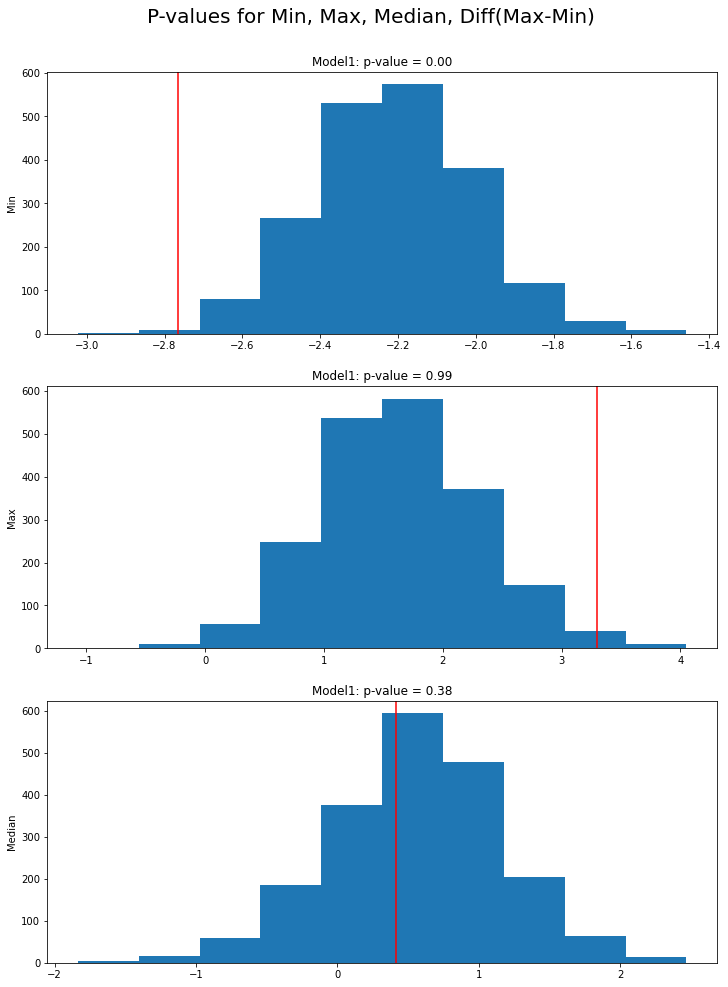

In [20]:
n_sim = 2000
n_models = len(SAMPLES)

fig, ax = plt.subplots(3, 1, figsize=(12, 9))
title = 'P-values for Min, Max, Median, Diff(Max-Min)'
fig.suptitle(title, fontsize=20, y=1.6)
fig.subplots_adjust(top=1.5)
ax[0].set_ylabel("Min")
ax[1].set_ylabel("Max")
ax[2].set_ylabel("Median")

# data- min, max, median
data_min, data_max, data_median = np.min(data_1['y']), np.max(data_1['y']), np.median(data_1['y'])

model, mus, sigmas, _ = SAMPLES[0]
# simulate y_rep
simulations = simulate(mus, sigmas, n_sim)
sim_min = np.min(simulations, axis=1)
sim_max = np.max(simulations, axis=1)
sim_median = np.median(simulations, axis=1)

# plot data values of test variables as vertical red lines
ax[0].axvline(data_min, color="red")
ax[1].axvline(data_max, color="red")
ax[2].axvline(data_median, color="red")

ax[0].hist(sim_min, zorder=-1)
ax[0].set_title(model+": p-value = {:.2f}".format(
    len(sim_min[sim_min < data_min])/len(sim_min)))
ax[1].hist(sim_max, zorder=-1)
ax[1].set_title(model+": p-value = {:.2f}".format(
    len(sim_max[sim_max < data_max])/len(sim_max)))
ax[2].hist(sim_median, zorder=-1)
_=ax[2].set_title(model+": p-value = {:.2f}".format(
    len(sim_median[sim_median < data_median])/len(sim_median)))

We can notice that the first model produced very good p-value (around 0.5) for the median, but did poorly with the minimum and maximum p-values.

### WAIC

We will now compute WAIC for each model.  
We hope that the second model will get better WAIC, due to the poor p-values of the first model.

In [21]:
# lppd
def get_lppd_model1(mmus, msigmas, n_sim=1000):
    lppd = 0
    for y in data_1['y']:
        idxs = np.random.choice(np.arange(mmus.shape[0]), size=n_sim)
        pdf0 = sp.stats.norm.pdf(y, loc=mmus[idxs,0], scale=msigmas[idxs,0])
        pdf1 = sp.stats.norm.pdf(y, loc=mmus[idxs,1], scale=msigmas[idxs,1])
        pdf2 = sp.stats.norm.pdf(y, loc=mmus[idxs,2], scale=msigmas[idxs,2])
        sum_pdf = np.maximum.reduce([pdf0, pdf1, pdf2]).sum()
        lppd += np.log(sum_pdf / n_sim)
    return lppd

def get_lppd_model2(mmus, msigmas, mbetas, n_sim=1000):
    lppd = 0
    for i in range(data_2['X'].shape[0]):
        x = data_2['X'][i].reshape(1, mbetas.shape[1])
        idxs = np.random.choice(np.arange(mmus.shape[0]), size=n_sim)
        betas = mbetas[idxs].reshape(n_sim, mbetas.shape[1]).T
        y = (x@betas).ravel()
        pdf0 = sp.stats.norm.pdf(y, loc=mmus[idxs,0], scale=msigmas[idxs,0])
        pdf1 = sp.stats.norm.pdf(y, loc=mmus[idxs,1], scale=msigmas[idxs,1])
        pdf2 = sp.stats.norm.pdf(y, loc=mmus[idxs,2], scale=msigmas[idxs,2])
        sum_pdf = np.maximum.reduce([pdf0, pdf1, pdf2]).sum()
        lppd += np.log(sum_pdf / n_sim)
    return lppd

In [22]:
# pwaic1
def get_pwaic1_model1(mmus, msigmas, n_sim=1000):
    pwaic1 = 0
    for y in data_1['y']:
        idxs = np.random.choice(np.arange(mmus.shape[0]), size=n_sim)
        pdf0 = sp.stats.norm.pdf(y, loc=mmus[idxs,0], scale=msigmas[idxs,0])
        pdf1 = sp.stats.norm.pdf(y, loc=mmus[idxs,1], scale=msigmas[idxs,1])
        pdf2 = sp.stats.norm.pdf(y, loc=mmus[idxs,2], scale=msigmas[idxs,2])
        sum_pdf = np.maximum.reduce([pdf0, pdf1, pdf2]).sum()
        sum_log_pdf = np.maximum.reduce([np.log(pdf0), np.log(pdf1), np.log(pdf2)]).sum()
        pwaic1 += np.log(sum_pdf / n_sim) - sum_log_pdf / n_sim
        
    return pwaic1*2

def get_pwaic1_model2(mmus, msigmas, mbetas, n_sim=1000):
    pwaic1 = 0
    for i in range(data_2['X'].shape[0]):
        x = data_2['X'][i].reshape(1, mbetas.shape[1])
        idxs = np.random.choice(np.arange(mmus.shape[0]), size=n_sim)
        betas = mbetas[idxs].reshape(n_sim, mbetas.shape[1]).T
        y = (x@betas).ravel()
        pdf0 = sp.stats.norm.pdf(y, loc=mmus[idxs,0], scale=msigmas[idxs,0])
        pdf1 = sp.stats.norm.pdf(y, loc=mmus[idxs,1], scale=msigmas[idxs,1])
        pdf2 = sp.stats.norm.pdf(y, loc=mmus[idxs,2], scale=msigmas[idxs,2])
        sum_pdf = np.maximum.reduce([pdf0, pdf1, pdf2]).sum()
        sum_log_pdf = np.maximum.reduce([np.log(pdf0), np.log(pdf1), np.log(pdf2)]).sum()
        pwaic1 += np.log(sum_pdf / n_sim) - sum_log_pdf / n_sim
        
    return pwaic1*2

In [23]:
# pwaic2
def get_pwaic2_model1(mmus, msigmas, n_sim=1000):
    pwaic2 = 0
    for y in data_1['y']:
        idxs = np.random.choice(np.arange(mmus.shape[0]), size=n_sim)
        pdf0 = sp.stats.norm.pdf(y, loc=mmus[idxs,0], scale=msigmas[idxs,0])
        pdf1 = sp.stats.norm.pdf(y, loc=mmus[idxs,1], scale=msigmas[idxs,1])
        pdf2 = sp.stats.norm.pdf(y, loc=mmus[idxs,2], scale=msigmas[idxs,2])
        log_pdf = np.maximum.reduce([np.log(pdf0), np.log(pdf1), np.log(pdf2)])
        pwaic2 += np.var(log_pdf, ddof=1)
    return pwaic2

def get_pwaic2_model2(mmus, msigmas, mbetas, n_sim=1000):
    pwaic2 = 0
    for i in range(data_2['X'].shape[0]):
        x = data_2['X'][i].reshape(1, mbetas.shape[1])
        idxs = np.random.choice(np.arange(mmus.shape[0]), size=n_sim)
        betas = mbetas[idxs].reshape(n_sim, mbetas.shape[1]).T
        y = (x@betas).ravel()
        pdf0 = sp.stats.norm.pdf(y, loc=mmus[idxs,0], scale=msigmas[idxs,0])
        pdf1 = sp.stats.norm.pdf(y, loc=mmus[idxs,1], scale=msigmas[idxs,1])
        pdf2 = sp.stats.norm.pdf(y, loc=mmus[idxs,2], scale=msigmas[idxs,2])
        log_pdf = np.maximum.reduce([np.log(pdf0), np.log(pdf1), np.log(pdf2)])
        pwaic2 += np.var(log_pdf, ddof=1)
    return pwaic2

In [24]:
lppd1 = get_lppd_model1(la1['mu'], la1['sigma'])
lppd2 = get_lppd_model2(la2['mu'], la2['sigma'], la2['beta'])
pwaic1_model1 = get_pwaic1_model1(la1['mu'], la1['sigma'])
pwaic1_model2 = get_pwaic1_model2(la2['mu'], la2['sigma'], la2['beta'])
print(f'WAIC of Model 1 by pwaic1:', round(-2*(lppd1-pwaic1_model1), 3))
print(f'WAIC of Model 2 by pwaic1:', round(-2*(lppd2-pwaic1_model2), 3))
pwaic2_model1 = get_pwaic2_model1(la1['mu'], la1['sigma'])
pwaic2_model2 = get_pwaic2_model2(la2['mu'], la2['sigma'], la2['beta'])
print(f'WAIC of Model 1 by pwaic2:', round(-2*(lppd1-pwaic2_model1), 3))
print(f'WAIC of Model 2 by pwaic2:', round(-2*(lppd2-pwaic2_model2), 3))

WAIC of Model 1 by pwaic1: 159.177
WAIC of Model 2 by pwaic1: 150.339
WAIC of Model 1 by pwaic2: 160.092
WAIC of Model 2 by pwaic2: 151.0


We can see that the second model outperformed the first model by both WAIC's metric methods (pwaic1 and pwaic2).

### Accuracy

Lastly, we will now compare the accuracy of both models against the actual labels.  
We will perform 1000 trials, in each we will predict the label for each data point by the Gauusian that gives the largest probabilty for that point.

In [25]:
def accuracy_model1(mmus, msigmas, n_trials=1000):
    y = data_1['y']
    n_data = len(y)
    n_samples = mmus.shape[0]
    labels_arr = pd.Categorical(iris_df['species']).codes
    accuaracys = 0
    for _ in range(n_trials):
        idxs = np.random.choice(np.arange(n_samples), size=n_data)
        pdfs = sp.stats.norm.pdf(y.reshape(n_data,1), loc=mmus[idxs], scale=msigmas[idxs])
        model_labels = np.argmax(pdfs, axis=1)
        accuaracys += (labels_arr == np.array(model_labels)).sum() / n_data

    return accuaracys / n_trials

In [26]:
def accuracy_model2(mmus, msigmas, mbetas, n_trials=1000):
    X = data_2['X']
    n_data = X.shape[0]
    n_samples = mmus.shape[0]
    labels_arr = pd.Categorical(iris_df['species']).codes
    accuaracys = 0
    for _ in range(n_trials):
        idxs = np.random.choice(np.arange(n_samples), size=n_data)
        y = np.diag(X@mbetas[idxs].squeeze(axis=2).T)
        pdfs = sp.stats.norm.pdf(y.reshape(n_data,1), loc=mmus[idxs], scale=msigmas[idxs])
        model_labels = np.argmax(pdfs, axis=1)
        accuaracys += (labels_arr == np.array(model_labels)).sum() / n_data

    return accuaracys / n_trials

In [27]:
print(f'Accuracy of Model 1: {accuracy_model1(la1["mu"], la1["sigma"]): .2%}')
print(f'Accuracy of Model 2: {accuracy_model2(la2["mu"], la2["sigma"], la2["beta"]): .2%}')

Accuracy of Model 1:  89.56%
Accuracy of Model 2:  89.95%


Model 2 shows a slight improvement in the accuracy comparing to model 1.

## Conclusion

We will choose model 2 over model 1 for the Iris dataset.  
Model 2 outperformed model 1 by both the WAIC and the accuracy.